<a href="https://colab.research.google.com/github/gangasani-anusha/RL-FinalProject/blob/main/Forecasting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib as plt
import warnings
import matplotlib.style as style
from urllib.request import urlretrieve
import os
warnings.filterwarnings('ignore')
style.use('fivethirtyeight')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
%pylab inline

def recreate_date_column(df):
    df['date'] = pd.to_datetime(df.index.map(lambda x: x.split('_')[1]))
    df['weekday'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['hour'] = df.index.map(lambda x: int(x.split('_')[2]))
    df = df.reset_index(drop=True)
    return df

Populating the interactive namespace from numpy and matplotlib


In [ ]:
weather = pd.read_csv('/content/sample_data/Weather.csv').drop('Unnamed: 0', 1)

weather = weather.rename(columns={'Date':'date'})
weather['date'] = pd.to_datetime(weather['date'])
weather.head()

,date,Temp,Humidity,WindSpeed,Precip
0,2016-07-01,78,65,8,0.0
1,2016-07-02,72,51,10,0.0
2,2016-07-03,71,62,6,0.0
3,2016-07-04,76,67,5,0.0
4,2016-07-05,82,71,8,0.0


In [ ]:
#Set Dates Here!
dates16 = pd.date_range(start=pd.datetime(2016, 8, 1), end=pd.datetime(2016, 10, 31),
                        freq='D')

dates17 = pd.date_range(start=pd.datetime(2017, 6, 1), end=pd.datetime(2017, 9, 30),
                        freq='D')                       

D = dates16.append(dates17)
dates = [x.date() for x in D]

path = 'data/'
years = ['2016', '2017']
months = ['06', '07', '08', '09', '10']

In [ ]:
BIKE = pd.DataFrame()
bikes = []

""""
Note that for some months, the column names were in upper case...we want to convert 
to lower case, so that monthly datasets can be easily appended. 
"""

standard_cols = ['tripduration', 'starttime', 'stoptime', 'start station id',
                     'start station name','start station latitude', 'start station longitude',
                     'end station id', 'end station name', 'end station latitude',
                     'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender']    
for y in years:
    for m in months:
        if (y == '2016' and m in ['04', '05', '06', '07']) or (y=='2017' and m == '10'):
            continue
        elif y == '2017':
            df = pd.read_csv("https://s3.amazonaws.com/tripdata/"+y+m+"-citibike-tripdata.csv.zip")
        #Need separate path to obtain 2016 data
        elif y == '2016':
            df = pd.read_csv("https://s3.amazonaws.com/tripdata/"+y+m+"-citibike-tripdata.zip")
        print(y, m)
        for c in range(len(df.columns.values)):
            df = df.rename(columns={df.columns.values[c]:standard_cols[c]})
        bikes.append(df)

for df in bikes:
    BIKE = BIKE.append(df)
BIKE.shape

2016 08
2016 09
2016 10
2017 06
2017 07
2017 08
2017 09


(11942180, 15)

In [ ]:
stats = BIKE[['start station id', 'start station name']].drop_duplicates() \
                                                        .reset_index(drop=True) 

IDs_smaller = [519, 392, 426, 497, 3164, 281, 3443, 304, 3375, 3283]    
#519: Pershing Square North
#392: Jay St & Tech Pl
#426: West St & Chambers St
#497: E 17 St & Broadway
#3164: Columbus Ave & W 72 St
#281: Grand Army Plaza & Central Park S
#3443: W 52 St & 6 Ave
#304: Broadway & Battery Pl
#3375: 3 Ave & E 72 St
#3283: W 89 St & Columbus Ave
#stats.T

In [ ]:
uni_dep_stations = BIKE[['start station id', 'start station name', 
                         'start station latitude', 'start station longitude']].drop_duplicates()

uni_arv_stations = BIKE[['end station id', 'end station name', 
                         'end station latitude', 'end station longitude']].drop_duplicates()

# Create a dataset with all unique station id, name, and lat/lon
uni_dep_stations.columns = ["id", "name", "lat", "lon"]
uni_arv_stations.columns = ["id", "name", "lat", "lon"]
uni_station = pd.concat([uni_dep_stations, uni_arv_stations], axis = 0).drop_duplicates()
uni_station.head()

Locations = uni_station[uni_station['id'].isin(IDs_smaller)].reset_index(drop=True)


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 16.7 MB 73.6 MB/s 
     |████████████████████████████████| 6.3 MB 71.5 MB/s 


In [ ]:
import geopandas as gpd
import os

url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

try:
    urlretrieve(url, "file.zip")
    if os.path.isfile("geo_export_04b91470-87bd-4f6c-bae8-406f62b9cb9a.shp"):
        print("Files exist. Pass.")
    else:
        !unzip file.zip
except:
    pass

nyc_map = gpd.GeoDataFrame.from_file("/content/geo_export_1eec5cd3-1351-4f4d-b679-bfaa132dab86.dbf")

Archive:  file.zip
  inflating: geo_export_2c7fbe9b-5ea4-4101-972b-2d77557e1c12.dbf  
  inflating: geo_export_2c7fbe9b-5ea4-4101-972b-2d77557e1c12.shp  
  inflating: geo_export_2c7fbe9b-5ea4-4101-972b-2d77557e1c12.shx  
  inflating: geo_export_2c7fbe9b-5ea4-4101-972b-2d77557e1c12.prj  


In [ ]:
Locations

,id,name,lat,lon
0,497,E 17 St & Broadway,40.737050,-73.990093
1,304,Broadway & Battery Pl,40.704633,-74.013617
2,519,Pershing Square North,40.751873,-73.977706
3,3164,Columbus Ave & W 72 St,40.777057,-73.978985
4,281,Grand Army Plaza & Central Park S,40.764397,-73.973715
5,426,West St & Chambers St,40.717548,-74.013221
6,3283,W 89 St & Columbus Ave,40.788221,-73.970416
7,392,Jay St & Tech Pl,40.695065,-73.987167
8,3375,3 Ave & E 72 St,40.769943,-73.960607
9,3443,W 52 St & 6 Ave,40.761330,-73.979820


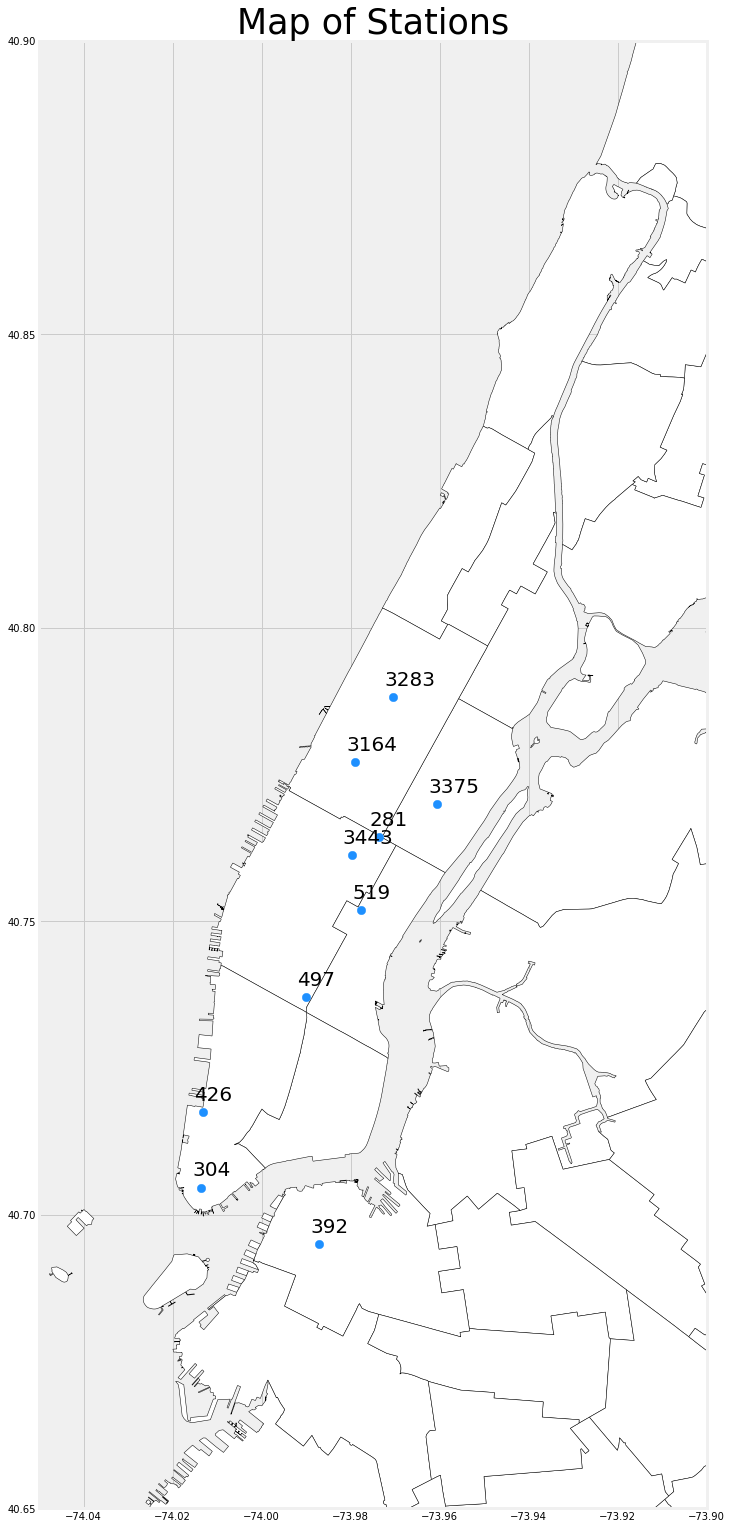

In [ ]:
ys = list(Locations['lat'])
xs = list(Locations['lon'])

f, ax = plt.subplots(figsize = (18, 27));
nyc_map.plot(ax = ax, color = "white", edgecolor = 'black');


plt.xlim((-74.05, -73.9));
plt.ylim((40.65, 40.9));
plt.scatter(xs, ys, color='dodgerblue', s=70);

for r in range(len(Locations)):
    lat = Locations.loc[r, 'lat']
    long = Locations.loc[r, 'lon']
    idx = Locations.loc[r, 'id']
    plt.annotate(idx, (long-0.002, lat+0.002), size=20)

plt.title("Map of Stations", size = 35);

519
392
426
497
3164
281
3443
304
3375
3283


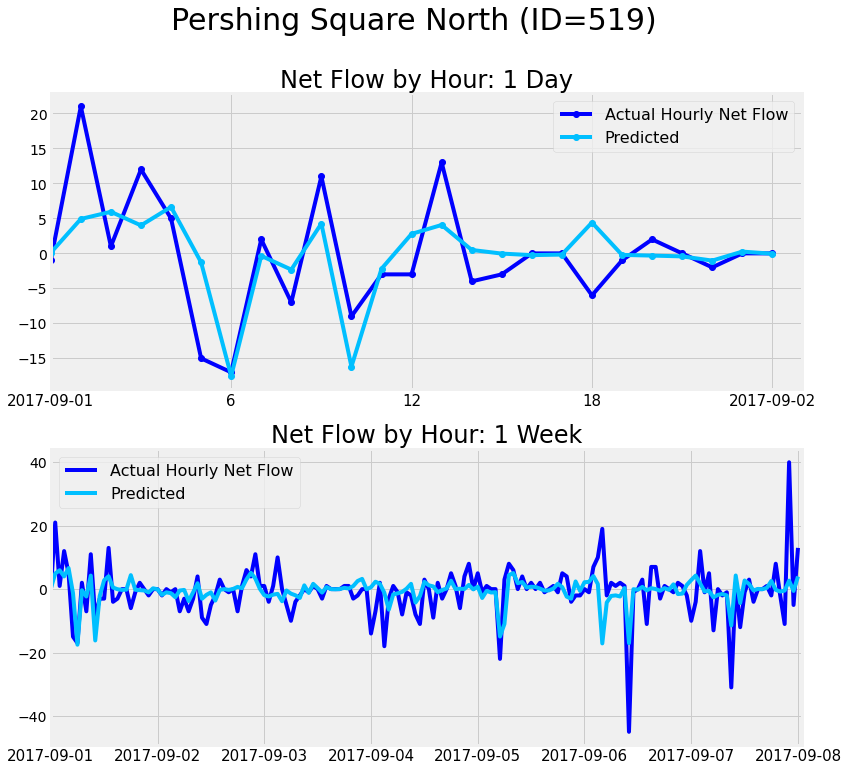

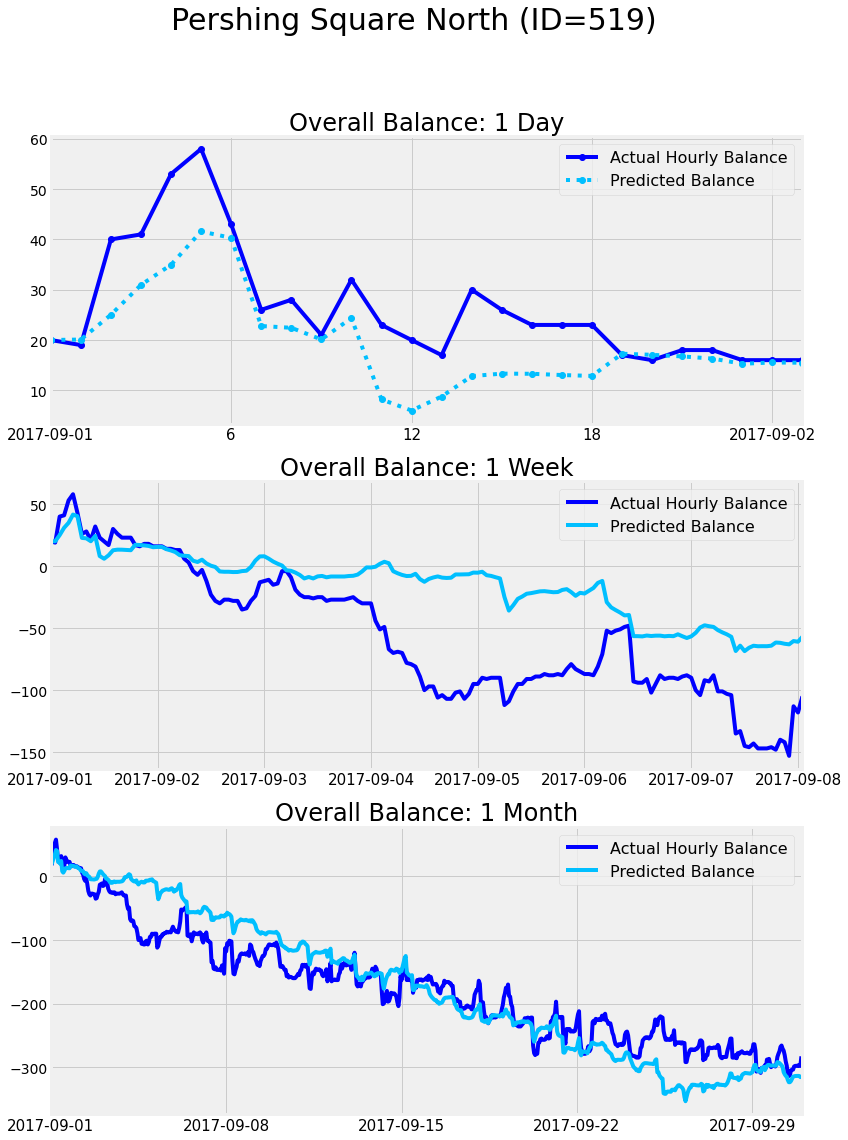

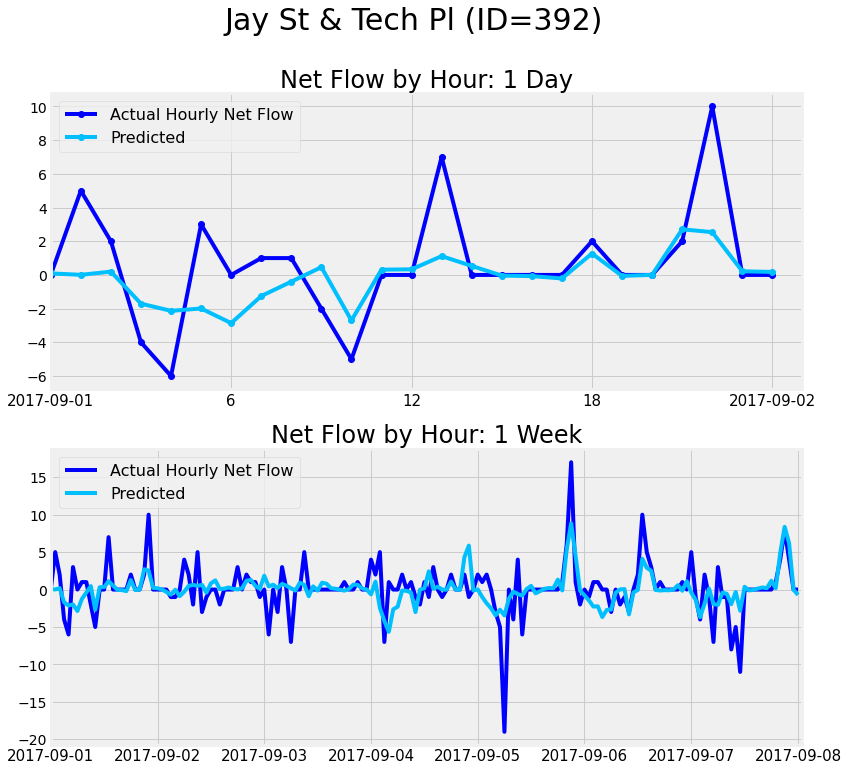

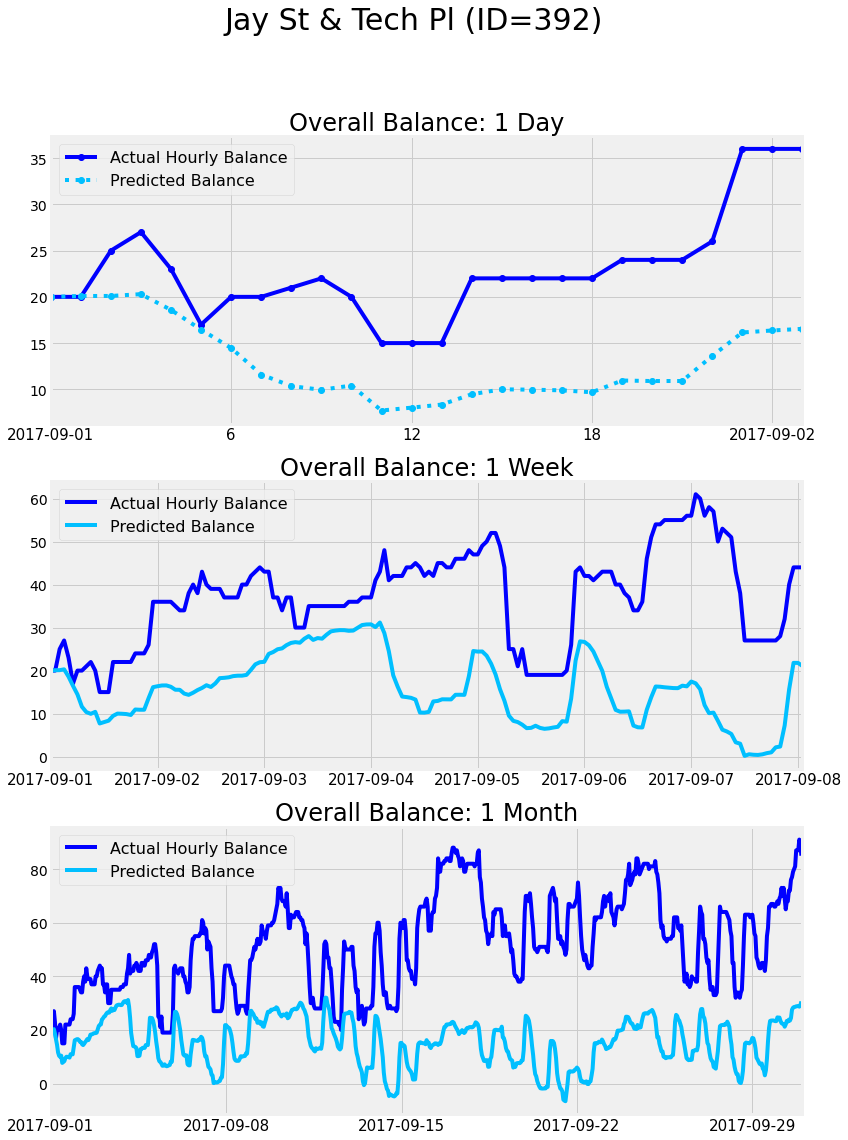

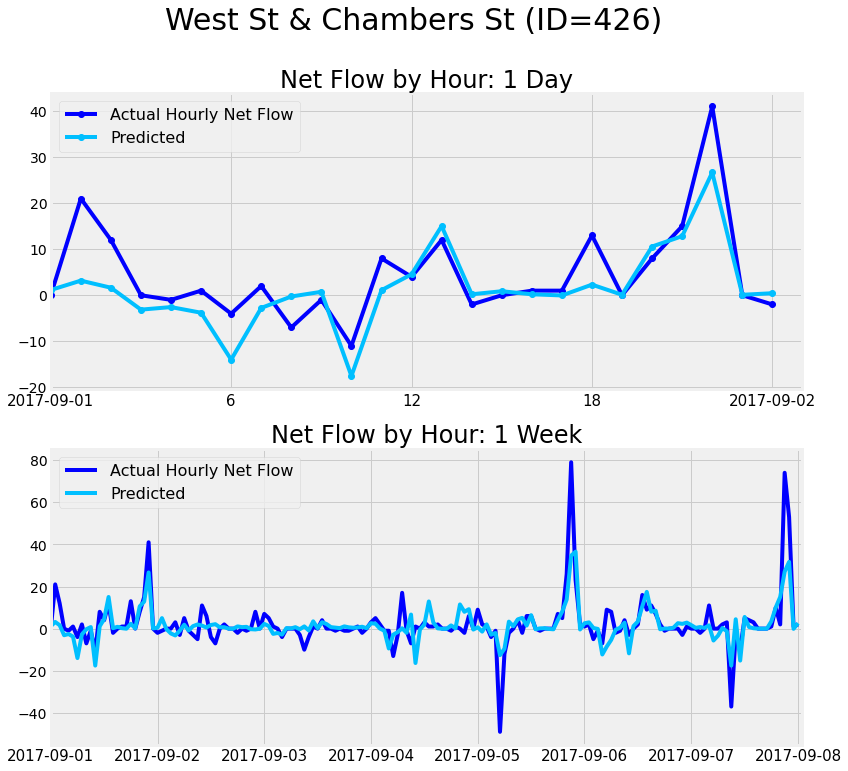

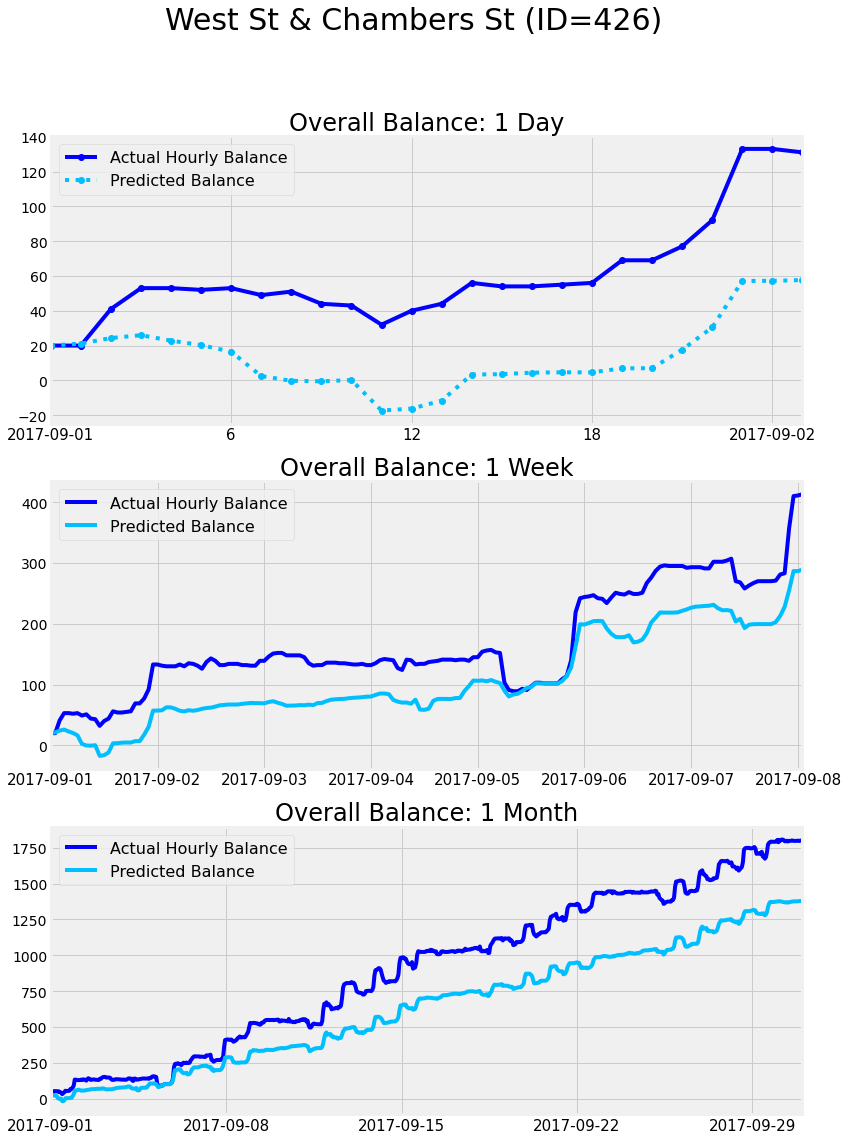

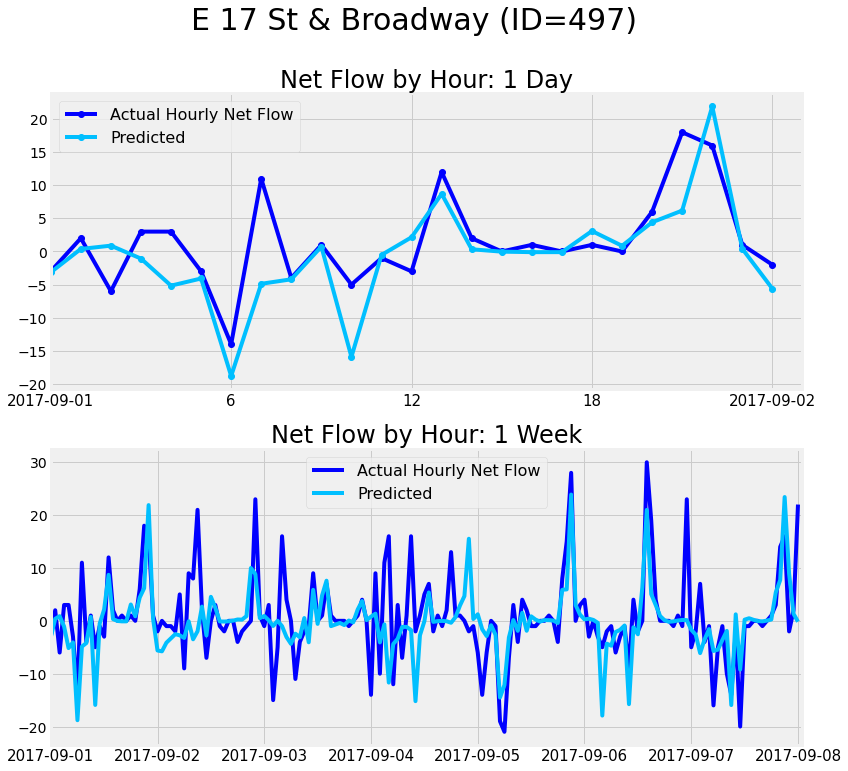

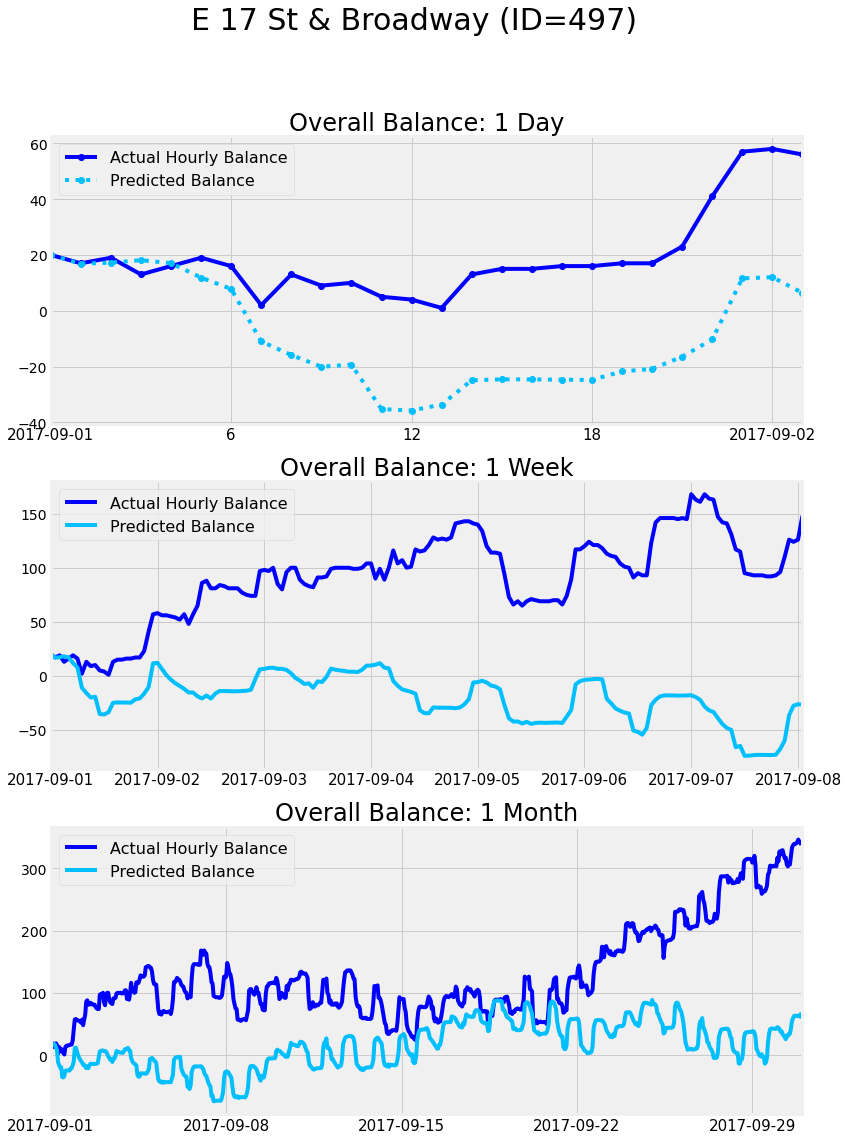

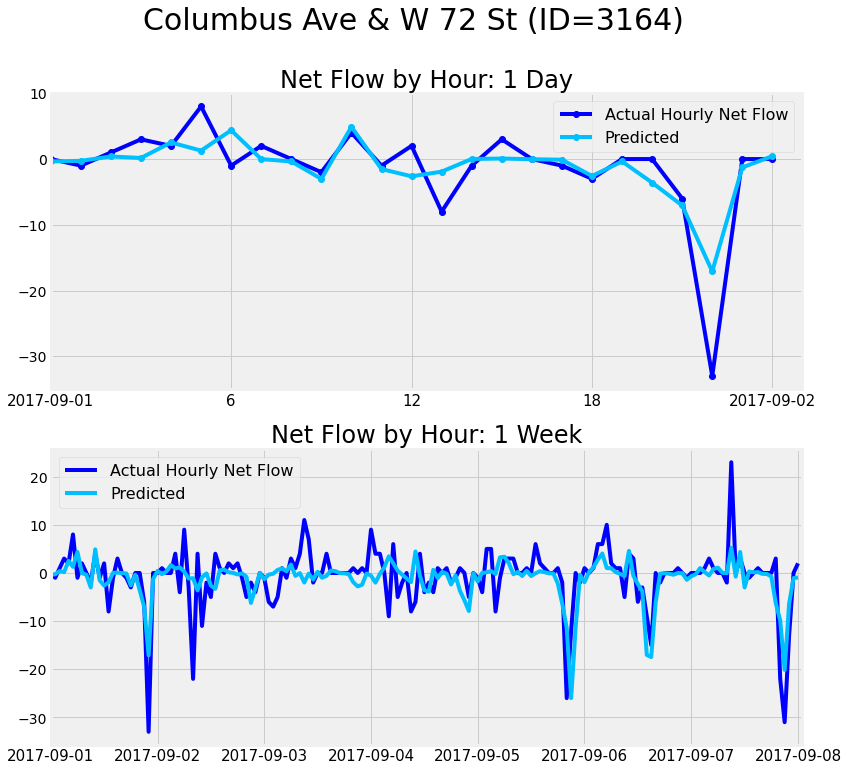

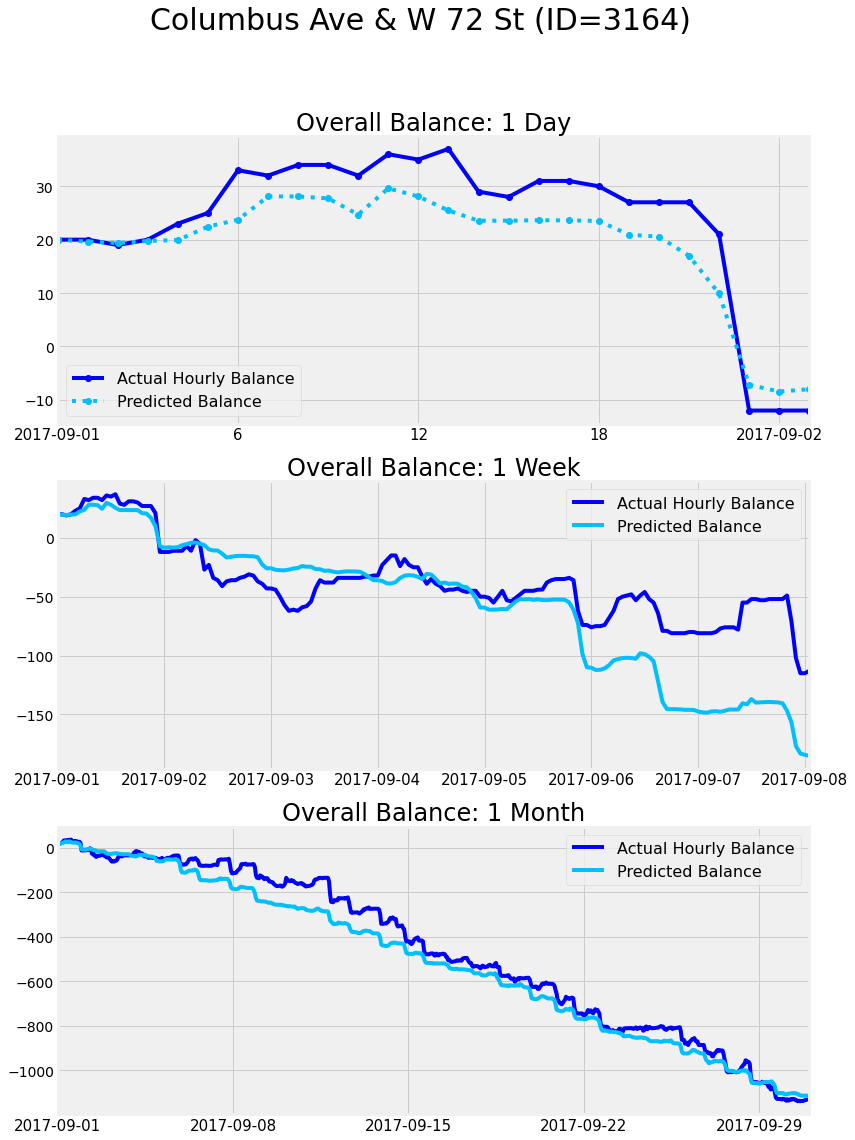

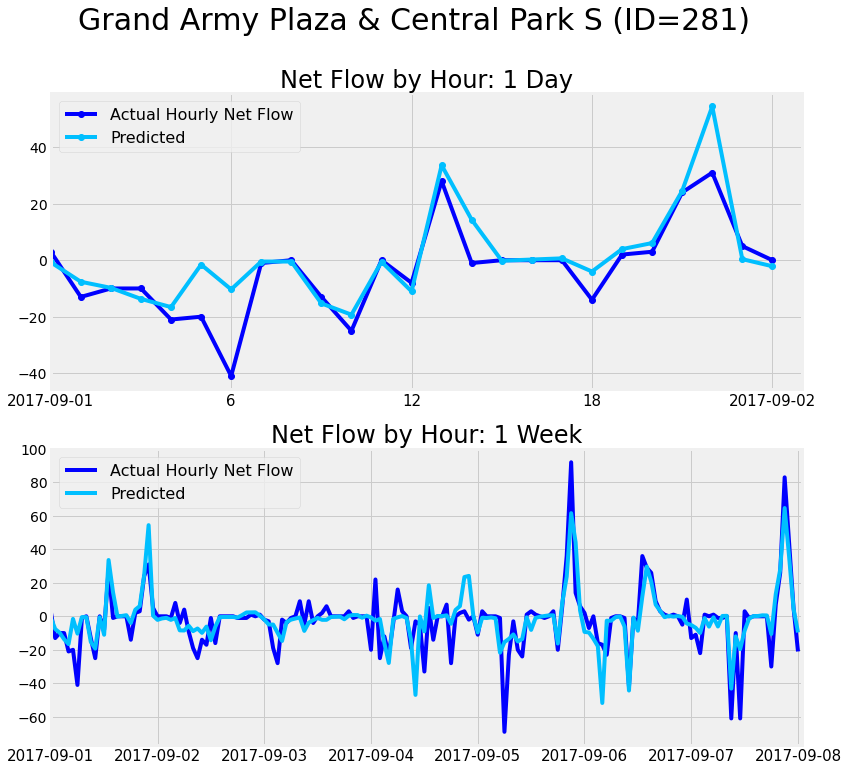

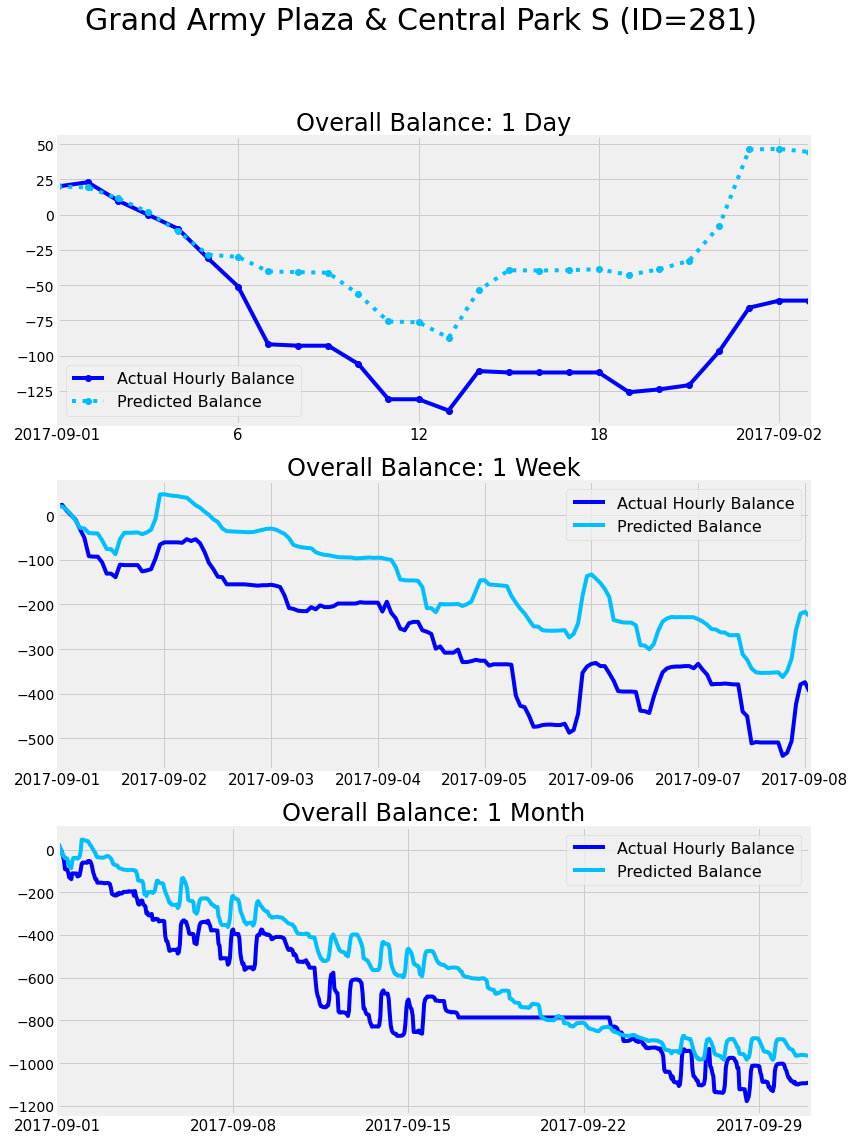

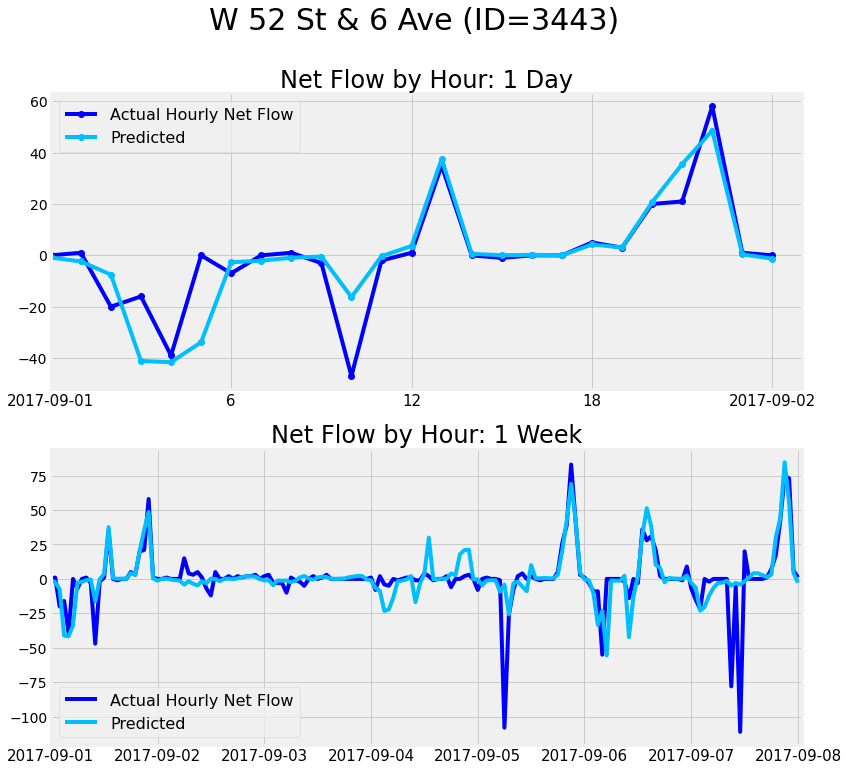

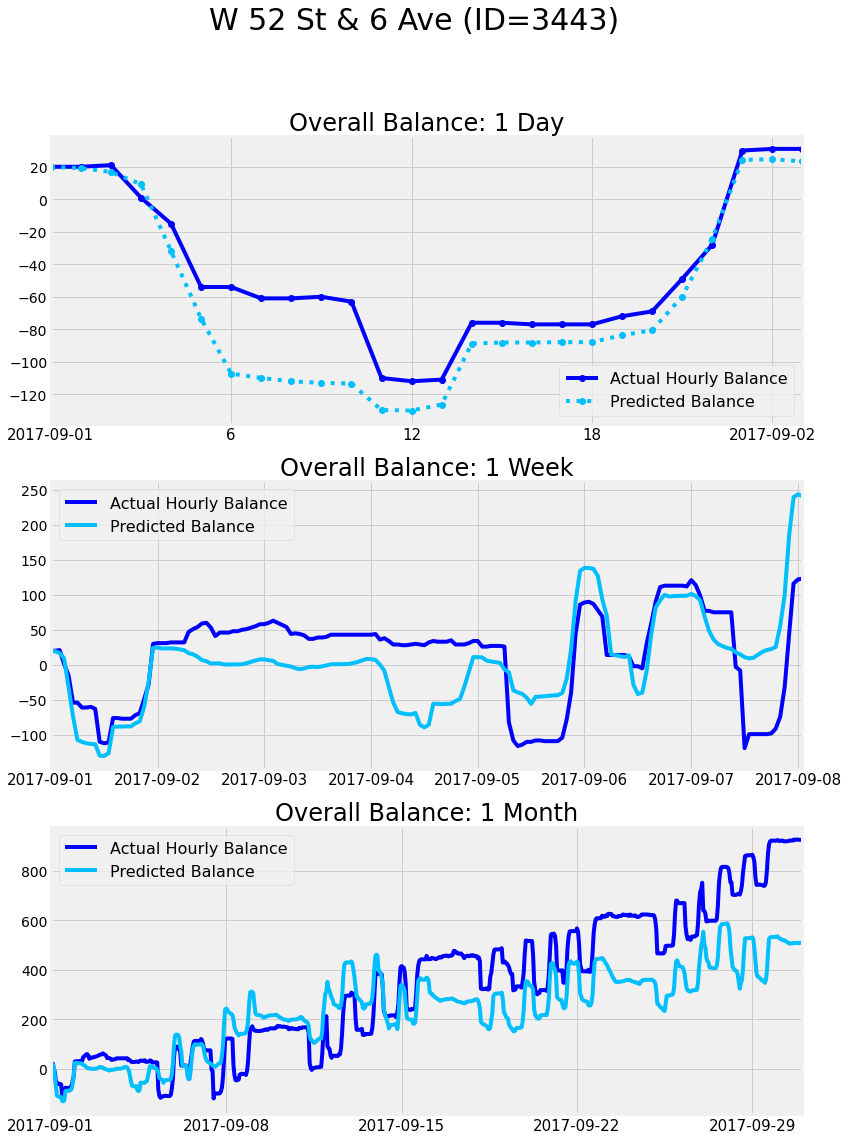

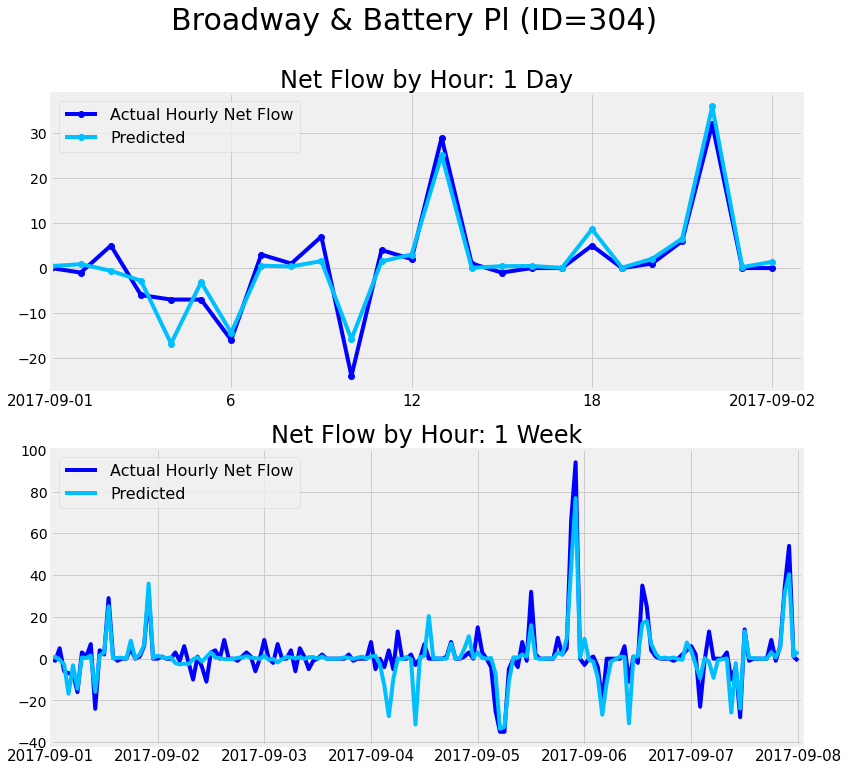

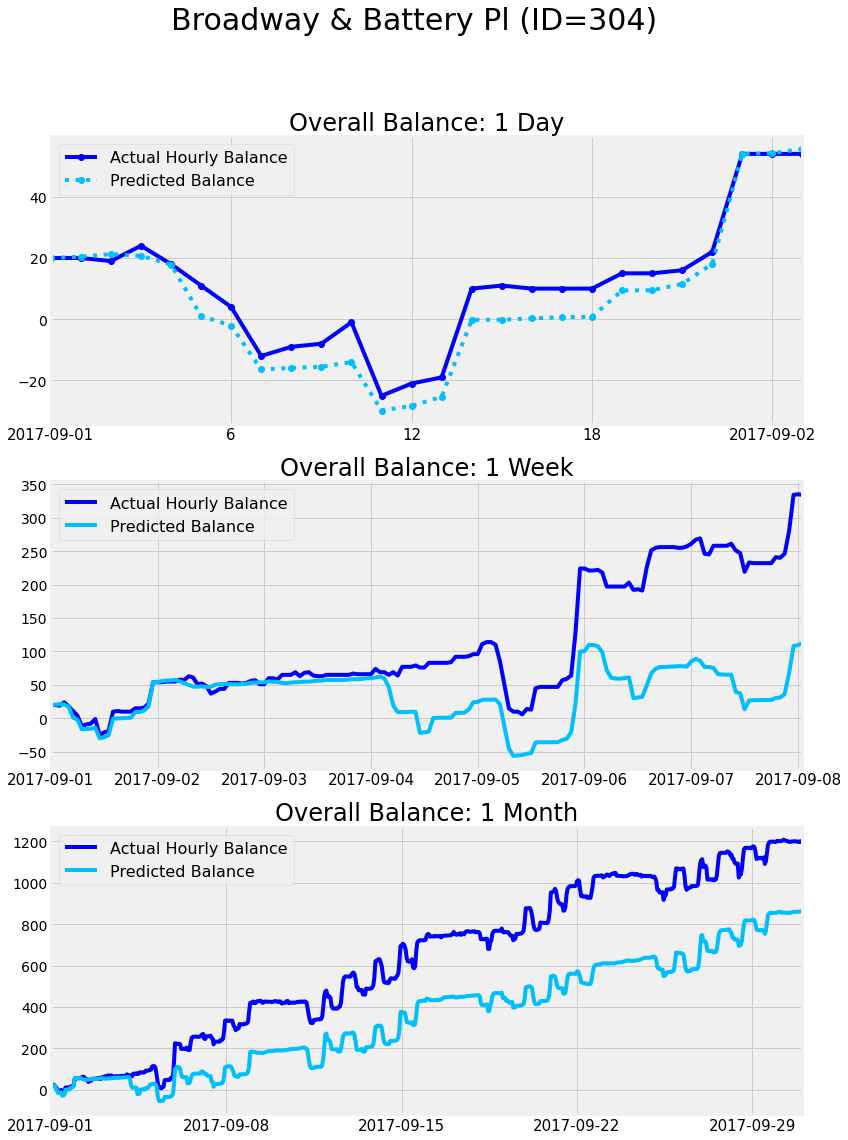

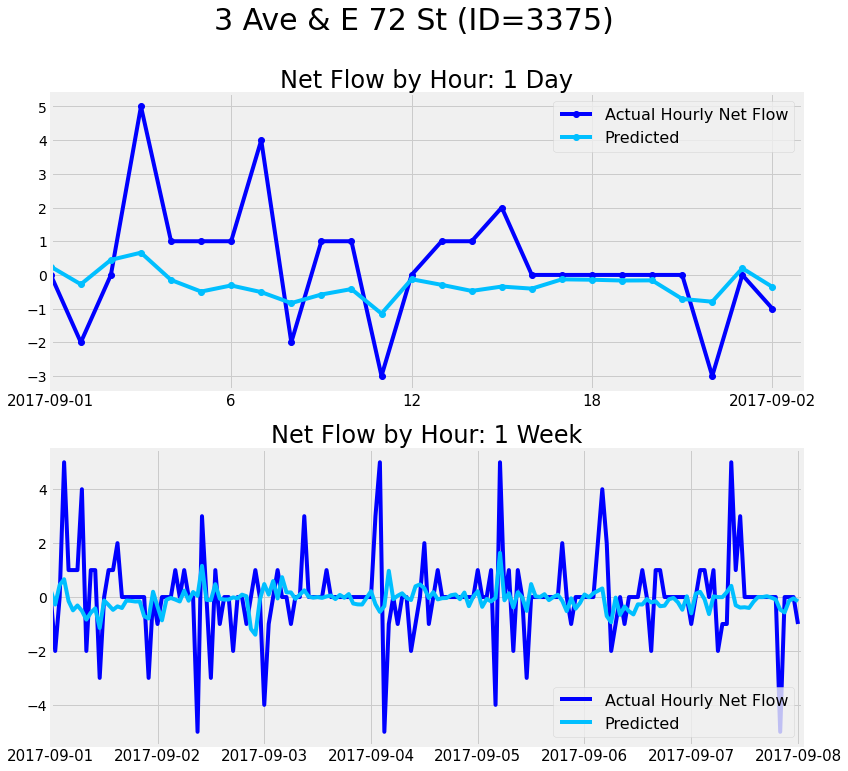

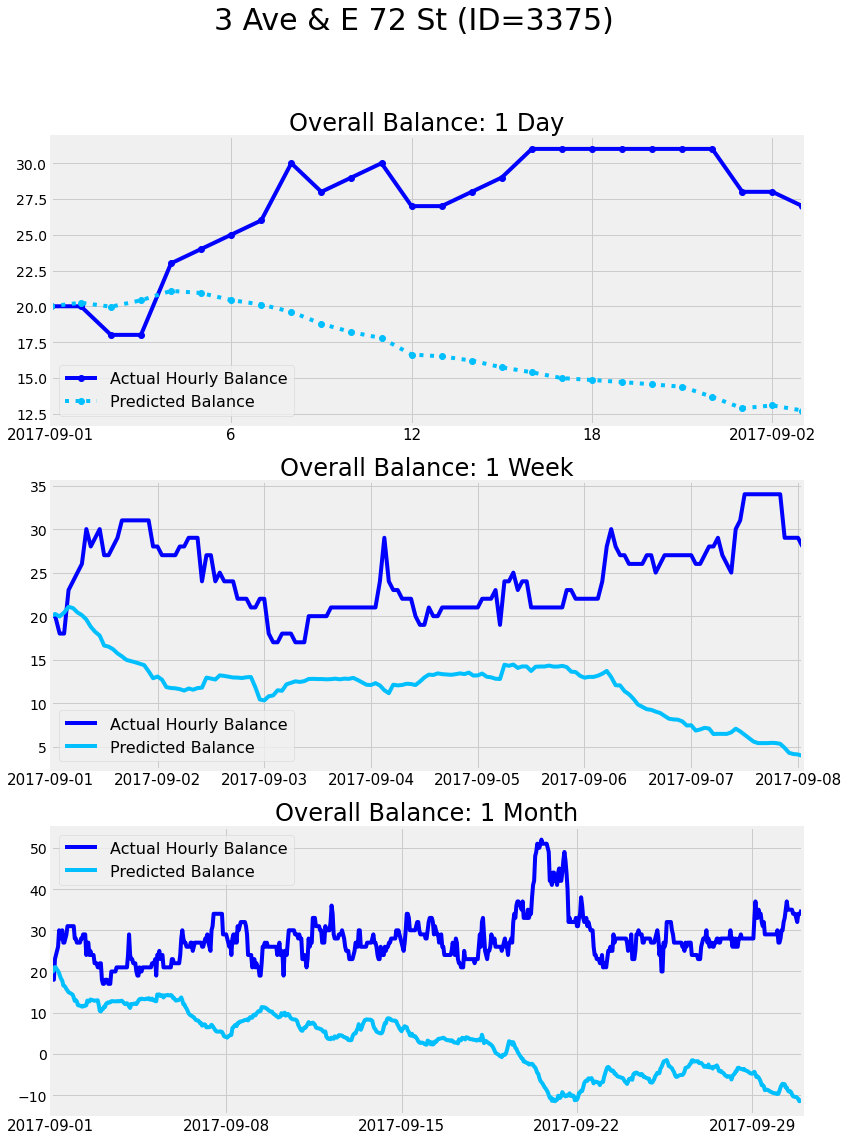

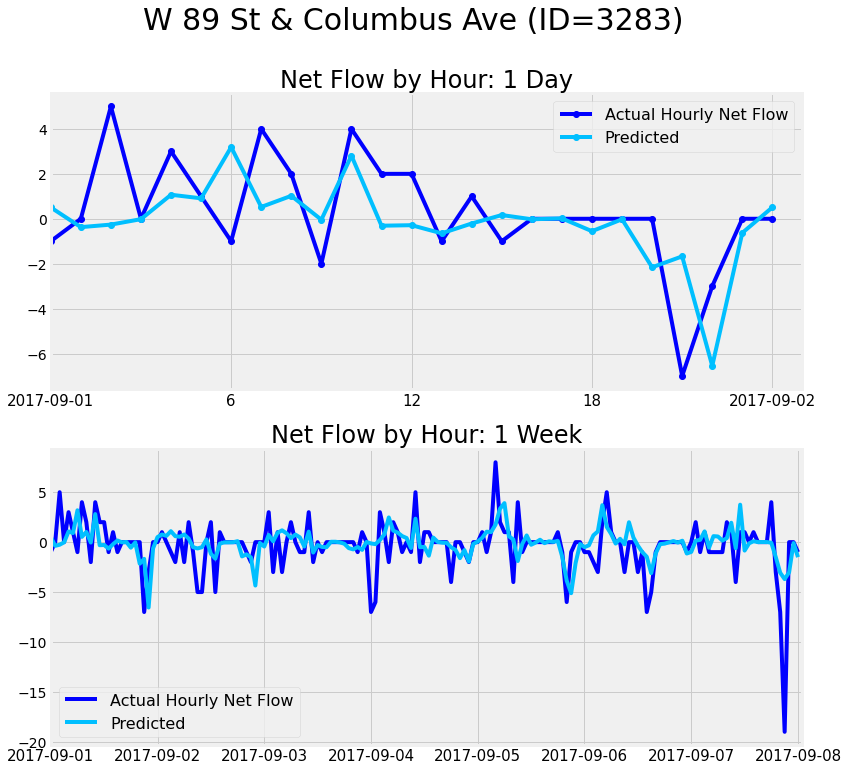

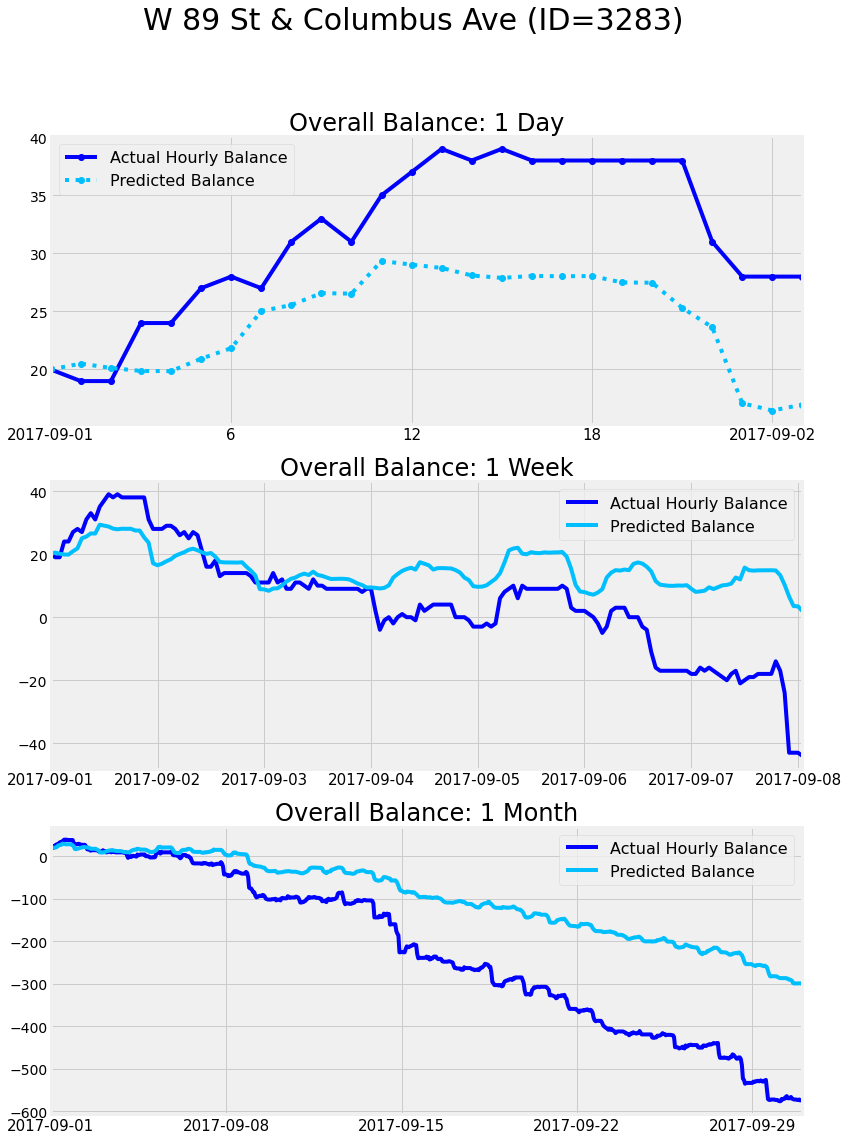

In [ ]:
TestR2s = []
TrainR2s = []
names = []
PREDS = {} #dict of sublists -- each sublist contains the predicted balances per station
BALANCES = {}
EXPECTED_BALANCES = {}
smallerIDs = [519, 392, 426, 497, 3164, 281, 3443, 304, 3375, 3283] 

for ID in smallerIDs:
    name = BIKE[BIKE['end station id']==ID].reset_index().loc[0, 'end station name']
    names.append(name)
    bike = BIKE[(BIKE['start station id'] == ID)|
            (BIKE['end station id'] == ID)].reset_index(drop=True)
    
    ### Parse date-time columns 
    bike['starttime'] = pd.to_datetime(bike['starttime'], infer_datetime_format= True)
    bike['stoptime'] = pd.to_datetime(bike['stoptime'], infer_datetime_format= True)

    bike['day'] = bike['starttime'].dt.day
    bike['start_hour'] = bike['starttime'].dt.hour
    bike['end_hour'] = bike['stoptime'].dt.hour
    bike['DOW'] = bike['starttime'].dt.dayofweek

    #Add date
    bike['date'] = bike['starttime'].dt.date
    
    # Create departure and arrival pivot tables
    monthDep = pd.pivot_table(bike[['start station id', 'date','start_hour','starttime']],
                             index = "start station id", columns=['date','start_hour'],
                             aggfunc = np.size, fill_value= 0).reset_index()

    monthDep.columns = ["dep_" + str(day).replace(' 00:00:00','') + "_" + str(hour) for _,day,hour in monthDep.columns]
    #monthDep.columns = ["dep_" + str(day).replace(' 00:00:00','') + "_" + str(hour) for day,hour in monthDep.columns]

    
    # Create hourly arrival count by day across the month
    monthArv = pd.pivot_table(bike[['end station id', 'date','end_hour', 'stoptime']],
                             index = "end station id", columns = ['date', "end_hour"], 
                             aggfunc = np.size, fill_value= 0).reset_index()

    #old
    monthArv.columns = ["arv_" + str(day).replace(' 00:00:00','') + "_" + str(hour) for _,day,hour in monthArv.columns]
    #monthArv.columns = ["arv_" + str(day).replace(' 00:00:00','') + "_" + str(hour) for day,hour in monthArv.columns]

    ### Merge departure and arrival tables, and create net table 
    StationActivity = monthDep.merge(monthArv, left_on = 'dep__', right_on = 'arv__')
    StationActivity = StationActivity.rename(columns={'dep__':'id'}).drop('arv__', 1)
    StationActivity = StationActivity[StationActivity['id']==ID]

    for day in dates:
        for hour in range(0, 24):
            net_col = "net_" + str(day) + "_" + str(hour)
            dep_col = "dep_" + str(day) + "_" + str(hour)
            arv_col = "arv_" + str(day) + "_" + str(hour)
            try:
                StationActivity[net_col] = StationActivity[arv_col]-StationActivity[dep_col]
            except (KeyError):
                if arv_col in StationActivity.columns.values:
                    StationActivity[dep_col] = 0
                elif dep_col in StationActivity.columns.values:
                    StationActivity[arv_col] = 0
                else:
                    StationActivity[arv_col] = 0
                    StationActivity[dep_col] = 0
                StationActivity[net_col] = StationActivity[arv_col]-StationActivity[dep_col]
    #-----------------------

    #Reshape data such that each row is one hour, and the columns 
    #are departures, arrivals, and net flows for that hour
    StationActivity = StationActivity.set_index(StationActivity['id'])

    net_cols = [x for x in StationActivity.columns.values if 'net' in x]
    dep_cols = [x for x in StationActivity.columns.values if 'dep' in x]
    arv_cols = [x for x in StationActivity.columns.values if 'arv' in x]

    nets = StationActivity[net_cols].T
    deps = StationActivity[dep_cols].T
    arvs = StationActivity[arv_cols].T

    nets = nets.rename(columns={ID:'nets'})
    deps = deps.rename(columns={ID:'deps'})
    arvs = arvs.rename(columns={ID:'arvs'})

    nets2 = recreate_date_column(nets)
    deps2 = recreate_date_column(deps)
    arvs2 = recreate_date_column(arvs)

    total = nets2.merge(deps2.merge(arvs2, on=['date', 'weekday', 'month', 'hour']), 
                                           on=['date', 'weekday', 'month', 'hour'])
    total = total.merge(weather, on=['date'])
    total = total.sort_values(by=['date']).reset_index(drop=True)


    # Introduce autoregressive features
    time_steps = list(np.arange(1,25))
    time_steps.extend([48, 72, 96, 120, 144, 168, 336, 504])

    for label in ['nets', 'deps']:
        #For each time step...
        for t in time_steps:
            lagged_starts = np.empty(t)
            lagged_starts[:] = np.nan
            lagged_starts = list(lagged_starts)
            lagged_starts.extend(list(total[label][:-t]))
            total[label+' t-'+str(t)] = lagged_starts
    
        #Complicated cleaning for t-336 and t-504
        total[label+' t-336'] = np.where((total[label+' t-336'].isnull())&(-total[label+' t-168'].isnull()),
                              total[label+' t-168'], total[label+' t-336'])
        total[label+' t-504'] = np.where((total[label+' t-504'].isnull())&(-total[label+' t-336'].isnull()),
                              total[label+' t-336'], total[label+' t-504'])
    
        total[label+'_12h'] = total.index.map(lambda x: total.loc[x, label+' t-1': label+' t-12'].sum())
        total[label+'_24h'] = total.index.map(lambda x: total.loc[x, label+' t-1': label+' t-24'].sum())
    
        total['hour_average_'+label+'_past_week'] = (total[label+' t-24']+total[label+' t-48']+total[label+' t-72']+ 
                                   total[label+' t-96']+total[label+' t-120']+total[label+' t-144']+
                                   total[label+' t-168'])/7
    
        total['hour_average_'+label+'_weekday_past3'] = (total[label+' t-168']+total[label+' t-336']+
                                                     total[label+' t-504'])/3
        #To avoid overfitting
        for x in time_steps:
            if x < 3:
                pass
            else:
                total = total.drop(label+' t-'+str(x), 1)
                
    ### Now that autoregressive features have been removed, delete June data 
    DF = total[total['month']!=6].reset_index(drop=True)
    dates = [x for x in dates if x.month !=6]
    
    
    # MODELING
    ### Predict Net Flow at a particular hour 
    cutoff = 3696 #for train-test split -- test data is September 1 2017, 12pm onward
    start = 168 #minimum at 168 hours -- (168 is first index with NO missing values)

    X = DF.drop(['date','nets', 'deps', 'arvs'], 1)
    y = DF['nets']

    TrainX = X[start:cutoff]
    TestX = X[cutoff:]
    TrainY = y[start:cutoff]
    TestY = y[cutoff:]

    RF = RandomForestRegressor(random_state=12, min_samples_leaf=5)
    RF.fit(TrainX, TrainY)
    preds = RF.predict(TestX) 
    
    #Keep track of results:
    TestR2s.append(round(RF.score(TestX, TestY),3))
    TrainR2s.append(round(RF.score(TrainX, TrainY), 3))
    
    ####
    ####
    # VISUALIZATION----------------------------------------
    label_locations = np.arange(0, len(X), 24)
    date_labels = [dates[x] for x in (label_locations/24).astype(int)]
    w_label_locations = np.arange(0, len(X), 168)
    w_date_labels = [dates[x] for x in (w_label_locations/24).astype(int)]
    starting_balance = 20 #by default
    
    hour_locations = np.arange(0, len(X), 6)
    hour_labels = [x % 24 for x in hour_locations]
    Dlabels = date_labels.copy()
    for z in range(len(hour_labels)):
        if z % 4 == 0:
            entry = int(z/4)
            hour_labels[z] = date_labels[entry]
    
    #---NET FLOW PLOTS
    plt.figure(figsize=[12, 12])
    plt.suptitle(name+' (ID='+str(ID)+')', size=30)

    #ONE DAY
    # Predicting Net Flow per Hour
    plt.subplot(211)
    plt.plot(y[cutoff:cutoff+25], marker='o', color='blue')
    plt.plot(pd.Series(preds[:25], index=np.arange(cutoff, cutoff+25, 1)), color='deepskyblue',
        marker='o')
    plt.xticks(hour_locations, hour_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, cutoff+25))
    plt.legend(['Actual Hourly Net Flow', 'Predicted'], fontsize=16)
    plt.title('Net Flow by Hour: 1 Day', size=24)

    #ONE WEEK
    plt.subplot(212)
    plt.plot(y[cutoff:cutoff+169], color='blue')
    plt.plot(pd.Series(preds[:169], index=np.arange(cutoff, cutoff+169, 1)), color='deepskyblue')
    plt.xticks(label_locations, date_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, cutoff+169))
    plt.legend(['Actual Hourly Net Flow', 'Predicted'], fontsize=16)
    plt.title('Net Flow by Hour: 1 Week', size=24)

    # os.mkdir('NetFlows/'+name)
    # plt.savefig('NetFlows/'+name+' ('+str(ID)+') Net Flows.pdf')
    # if ID != 519:
    #     plt.close()

    #BALANCE PLOTS
    #early_hours is midnight to noon on 9/1
    early_hours = pd.Series(0, index=[3695]).append(np.cumsum(TestY.head(12))) 
    early_hours = early_hours + starting_balance
    real_start_balance = np.array(early_hours)[-1]

    cumulative_actuals = np.cumsum(TestY.loc[cutoff+12:]) + real_start_balance
    total_actual = pd.concat([early_hours, cumulative_actuals])
    total_actual = total_actual.shift(periods=1)

    cumulative_preds = pd.Series(np.cumsum(preds),index=np.arange(cutoff, cutoff+len(preds)))
    cumulative_preds = pd.Series(0, index=[3695]).append(cumulative_preds)
    cumulative_preds = cumulative_preds + starting_balance
    cumulative_preds = cumulative_preds.shift(periods=1)
    
    #-----------Plots
    plt.figure(figsize=[12, 18])
    plt.suptitle(name+' (ID='+str(ID)+')', size=30)

    #Daily Map
    plt.subplot(311)
    plt.plot(total_actual.loc[cutoff:cutoff+25], marker='o', color='blue')
    plt.plot(cumulative_preds.loc[cutoff:cutoff+25], marker = 'o', color = 'deepskyblue', linestyle=':')
    plt.xticks(hour_locations, hour_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, cutoff+25))
    plt.legend(['Actual Hourly Balance', 'Predicted Balance'], fontsize=16)
    plt.title('Overall Balance: 1 Day', size=24)

    #Weekly Map
    plt.subplot(312)
    plt.plot(total_actual.loc[cutoff:cutoff+169], color='blue')
    plt.plot(cumulative_preds.loc[cutoff:cutoff+169], color = 'deepskyblue')
    plt.xticks(label_locations, date_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, cutoff+169))
    plt.legend(['Actual Hourly Balance', 'Predicted Balance'], fontsize=16)
    plt.title('Overall Balance: 1 Week', size=24)

    #Monthly Map
    plt.subplot(313)
    plt.plot(total_actual, color='blue')
    plt.plot(cumulative_preds, color = 'deepskyblue')
    plt.xticks(w_label_locations, w_date_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, len(y+1)))
    plt.legend(['Actual Hourly Balance', 'Predicted Balance'], fontsize=16)
    plt.title('Overall Balance: 1 Month', size=24)
    
    # plt.savefig('Balances/'+name+' ('+str(ID)+') Balances.pdf')
    # if ID != 519:
    #     plt.close()
    
    ##JSON FILES
    P = preds[1:24]
    P = [int(round(p)) for p in P]
    PREDS[ID] = P
    
    balances = np.append(0, np.cumsum(TestY.loc[3697:3719]))+20
    balances = [int(b) for b in balances]
    BALANCES[ID] = balances
    
    ExpectedBalance_1Hour = [balances[y]+P[y] for y in range(len(P))]
    E = [int(x) for x in ExpectedBalance_1Hour]
    EXPECTED_BALANCES[ID] = E
    
    print(ID)

In [ ]:
len(EXPECTED_BALANCES)

10

In [ ]:
import json
with open('PREDS.json', 'w') as outfile:  
    json.dump(PREDS, outfile)
with open('BALANCES.json', 'w') as outfile:  
    json.dump(BALANCES, outfile)
with open('EXPECTED_BALANCES.json', 'w') as outfile:  
    json.dump(EXPECTED_BALANCES, outfile)

Text(0.5, 1.0, 'Predicted Balance: 1 Hour in Advance')

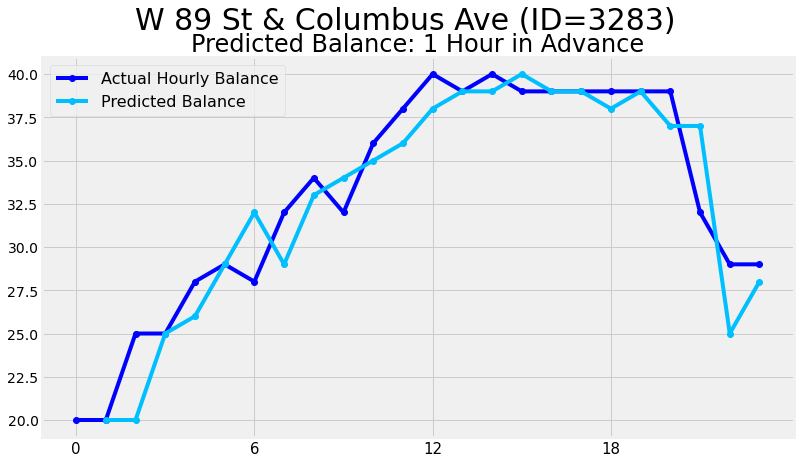

In [ ]:
E = np.append(ExpectedBalance_1Hour, 56)
PP = np.append(P, 0)
plot_chart = pd.DataFrame(np.vstack((balances, PP, E))).T
plot_chart = plot_chart.rename(columns={0: 'Current Balance', 
                                        1: 'Predicted Change in\n Next Hour',
                                       2: 'Predicted Balance in Next Hour'})


plt.figure(figsize=[12, 7])
plt.suptitle(name+' (ID='+str(ID)+')\n', size=30)

plt.subplot(111)
plt.plot(plot_chart['Current Balance'], marker='o', color='blue')
plt.plot(np.arange(1, 24), ExpectedBalance_1Hour, marker = 'o', 
         color = 'deepskyblue')
plt.xticks(np.arange(0, 24, 6), size=15)
plt.yticks(size=14)
plt.legend(['Actual Hourly Balance', 'Predicted Balance'], fontsize=16)
plt.title('Predicted Balance: 1 Hour in Advance', size=24)

In [ ]:

plot_chart

,Current Balance,Predicted Change in\n Next Hour,Predicted Balance in Next Hour
0,20,0,20
1,20,0,20
2,25,0,25
3,25,1,26
4,28,1,29
5,29,3,32
6,28,1,29
7,32,1,33
8,34,0,34
9,32,3,35


In [ ]:
ForecastResults = pd.DataFrame(np.vstack((smallerIDs, names, TestR2s, TrainR2s))).T
ForecastResults = ForecastResults.rename(columns={0:'StationID', 1: 'Name',
                                                 2:'Test R^2', 3:'Train R^2'})
ForecastResults

,StationID,Name,Test R^2,Train R^2
0,519,Pershing Square North,0.41,0.697
1,392,Jay St & Tech Pl,0.442,0.73
2,426,West St & Chambers St,0.649,0.832
3,497,E 17 St & Broadway,0.489,0.807
4,3164,Columbus Ave & W 72 St,0.483,0.774
5,281,Grand Army Plaza & Central Park S,0.593,0.864
6,3443,W 52 St & 6 Ave,0.586,0.845
7,304,Broadway & Battery Pl,0.807,0.897
8,3375,3 Ave & E 72 St,0.062,0.543
9,3283,W 89 St & Columbus Ave,0.276,0.647


In [ ]:
Ftable = pd.DataFrame(np.vstack((X.columns.values, RF.feature_importances_))).T. \
                        sort_values(by=1, ascending=False)
    
Ftable = Ftable.reset_index(drop=True).rename(columns={0: 'Feature Name', 1:'Gini Coeff.'})
Ftable

,Feature Name,Gini Coeff.
0,hour,0.179878
1,hour_average_nets_past_week,0.115511
2,nets t-1,0.086251
3,deps_24h,0.065478
4,deps_12h,0.064083
5,deps t-1,0.058016
6,nets_24h,0.057901
7,hour_average_deps_past_week,0.050752
8,Humidity,0.045532
9,weekday,0.043496


In [ ]:
import json
with open('EXPECTED_BALANCES.json') as outfile:  
    EXPECTED_BALANCES = json.load(outfile)

with open('BALANCES.json') as b:
    BALANCES = json.load(b)

with open('PREDS.json') as j:
    PREDS = json.load(j)